# NLP - Text Classification
### Corona Virus Tagged tweets text data

**Task**  
Perform Text Classification on the tweets pulled from Twitter.

**Models**  
I used a baseline Naive Bayes model and a Neural Network archiecture using DistilBERT as the embedding layer with a LSTM and Dense layers following. I used huggingface's transformers library and tensorflow for the deep learning model and scikit-learn for the naive bayes model. I also used GPU acceleration for training the neural network. 

<hr>

#Block 1

**Imports**

In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 693 kB/s 
     |████████████████████████████████| 7.6 MB 64.0 MB/s 
     |████████████████████████████████| 182 kB 80.1 MB/s 


In [2]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # Hidding Huggingface Warnings
warnings.filterwarnings("ignore")

#Block 2

Enabling GPU

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
plt.style.use('ggplot')

In [5]:
MODEL_NAME = 'distilbert-base-cased'

#Block 3

### Loading Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
test_df = pd.read_csv('/content/drive/MyDrive/archive/Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')
train_df = pd.read_csv('/content/drive/MyDrive/archive/Corona_NLP_test.csv', encoding = "UTF-8", encoding_errors='ignore')

In [8]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [9]:
test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


*Dropping any duplicates or missing values*

In [10]:
train_df.drop_duplicates(inplace= True)
test_df.drop_duplicates(inplace=True)

In [11]:
train_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [12]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

Because a missing location is not as important as a missing tweet or sentiment, I will not remove those entires.

In [13]:
print(f"There are {train_df.shape[0]} entries in the training dataframe")
train_df.head()

There are 3798 entries in the training dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [14]:
print(f"There are {test_df.shape[0]} entries in the test dataframe")
test_df.head()

There are 3798 entries in the test dataframe


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


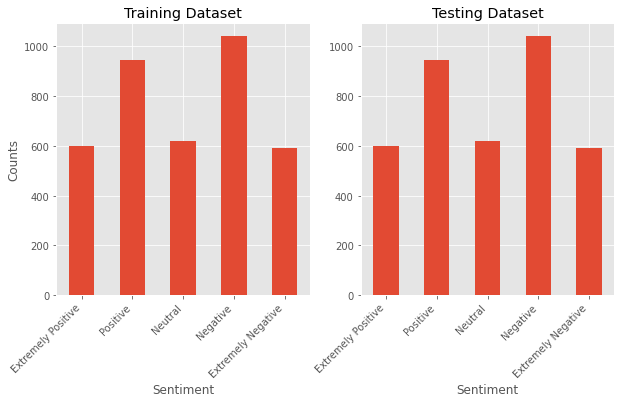

In [15]:
reorder = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')

test_df.value_counts('Sentiment').reindex(index=reorder).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Dataset');

It looks like the training and testsing datasets are not balanced across all categories.

In [16]:
max_words = []
for row in train_df['OriginalTweet']:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")

The max word count is 62


**Getting rid of the URL's in the tweets**

In [17]:
test_str = test_df['OriginalTweet'][0]
print(test_str)

def remove_https(row):
    return re.sub(r'http\S+', '', row)

remove_https(test_str)

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1


'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up  '

*Apply to whole datasets*

In [18]:
train_df['OriginalTweet_no_URL'] = train_df['OriginalTweet'].apply(remove_https)
test_df['OriginalTweet_no_URL'] = test_df['OriginalTweet'].apply(remove_https)

In [19]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_no_URL
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING: New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,#Panic buying hits #NewYork City as anxious sh...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,Meanwhile In A Supermarket in Israel -- People...
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,Did you panic buy a lot of non-perishable item...
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,Asst Prof of Economics @cconces was on @NBCPhi...
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,Gov need to do somethings instead of biar je r...


#Block 4

**Label Encode the datasets**

In [20]:
le = LabelEncoder()
train_df['Sentiment_label'] = le.fit_transform(train_df['Sentiment'])
test_df['Sentiment_label'] = le.transform(test_df['Sentiment'])

In [21]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet_no_URL,Sentiment_label
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING: New Yorkers encounter empty supermar...,0
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn't find hand sanitizer at Fred Me...,4
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...,1
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,#Panic buying hits #NewYork City as anxious sh...,2
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronav...,3
...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,Meanwhile In A Supermarket in Israel -- People...,4
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,Did you panic buy a lot of non-perishable item...,2
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,Asst Prof of Economics @cconces was on @NBCPhi...,3
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,Gov need to do somethings instead of biar je r...,0


In [22]:
label_dict = (test_df[['Sentiment','Sentiment_label']].drop_duplicates()
              .sort_values(by='Sentiment_label')
              .reset_index(drop=True)['Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Extremely Negative
1 Extremely Positive
2 Negative
3 Neutral
4 Positive


#Block 5

**Splitting the data**

I will take 10% of the training data as validation data

In [23]:
# Get the number training samples
num_train_samples = int(train_df.shape[0] * 0.9)

x_train = train_df['OriginalTweet_no_URL'][:num_train_samples]
y_train = train_df['Sentiment_label'][:num_train_samples]
x_val = train_df['OriginalTweet_no_URL'][num_train_samples:]
y_val = train_df['Sentiment_label'][num_train_samples:]

### Sanity Check
assert(len(x_train) + len(x_val) == train_df.shape[0])

print(f"{len(x_train)} training examples\n{len(x_val)} validation examples")

3418 training examples
380 validation examples


In [24]:
x_test = test_df['OriginalTweet_no_URL']
y_test = test_df['Sentiment_label']
print(f"{len(x_test)} testing examples")

3798 testing examples


In [25]:
x_test

0       TRENDING: New Yorkers encounter empty supermar...
1       When I couldn't find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3       #Panic buying hits #NewYork City as anxious sh...
4       #toiletpaper #dunnypaper #coronavirus #coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet_no_URL, Length: 3798, dtype: object

#Block 6

## Naive Bayes (Baseline Model)

Pre-processing by:  
- remove punctuations (except #)
- lowercase all words
- removing stopwords
- stemming words

*Note: I will not remove the **#** symbol because it is a predominant part of what makes tweets unique*

In [26]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Remove all puncutation
def clean_responses(text):
    ### Remove all puncutation
    string.punctuation = string.punctuation.replace('#','')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    
    ### Lowercase
    text = text.lower()
    
    ### Removing stop words
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            filtered_words.append(word)
            
    ### Stemming words
    stemmed = [porter.stem(word) for word in filtered_words]
                
    return ' '.join(stemmed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
X_train_NB = train_df['OriginalTweet_no_URL'].apply(clean_responses)
y_train_NB = train_df['Sentiment_label']
X_test_NB = test_df['OriginalTweet_no_URL'].apply(clean_responses)
y_test_NB = test_df['Sentiment_label']

#Block 7

In [28]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

#Block 8

**Results of Naive Bayes model**

Accuracy: 0.5763559768299105


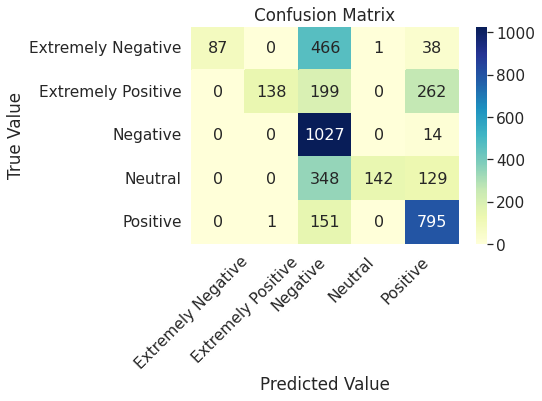

In [29]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_5 = ['Extremely Negative','Extremely Positive','Negative','Neutral','Positive'] 

def print_cf1(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_5,columns=[0,1,2,3,4]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2,3,4], labels_5, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf1(y_test_NB, y_hat)

In [30]:
print(classification_report(y_test_NB, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       1.00      0.15      0.26       592
Extremely Positive       0.99      0.23      0.37       599
          Negative       0.47      0.99      0.64      1041
           Neutral       0.99      0.23      0.37       619
          Positive       0.64      0.84      0.73       947

          accuracy                           0.58      3798
         macro avg       0.82      0.49      0.47      3798
      weighted avg       0.76      0.58      0.52      3798



## DistilBERT

#Block 9

**Tokenize the Inputs** 

In [31]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Loading the tokenizer

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

*Finding the max token sequence in the training set*

In [32]:
max_val = 0
for sent in (x_train.tolist() + x_val.tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 141


I will set the max length and input for the deep learning model to 143  
*(Max token length + 2 for special characters [CLS] and [SEP])*

In [66]:
MAX_LENGTH = 143

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])     
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')

In [ ]:
X_train = tokenize(x_train, tokenizer)
X_test = tokenize(x_test, tokenizer)
X_val = tokenize(x_val, tokenizer)

**Looking at entry**

In [35]:
index_num = 5

print(train_df.loc[index_num]['Sentiment'], '\n')

print(x_train[index_num], '\n')

temp_tokens = tokenizer.tokenize(x_train[index_num])
temp_ids = tokenizer.encode(x_train[index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

Neutral 

Do you remember the last time you paid $2.99 a gallon for regular gas in Los Angeles?Prices at the pump are going down. A look at how the #coronavirus is impacting prices. 4pm @ABC7  

ID's	Input Tokens
101	[CLS]
2091	Do
1128	you
2676	remember
1103	the
1314	last
1159	time
1128	you
3004	paid
109	$
123	2
119	.
4850	99
170	a
20003	gal
4934	##lon
1111	for
2366	regular
3245	gas
1107	in
2238	Los
2460	Angeles
136	?
7510	Price
1116	##s
1120	at
1103	the
11188	pump
1132	are
1280	going
1205	down
119	.
138	A
1440	look
1120	at
1293	how
1103	the
108	#
1884	co
15789	##rona
27608	##virus
1110	is
3772	impact
1158	##ing
7352	prices
119	.
125	4
9952	##pm
137	@
5254	ABC
1559	##7
102	[SEP]


#Block 10

### Creating the model

In [36]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 143)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 143)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 143, 768),                                                   
                                 hidden_states=((No                                           

#Block 11

*Creating a output directory to store the models weights*

In [37]:
### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

#Block 12

*Callbacks*

In [38]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr =    ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

#Block 13

**Compile and train**

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
214/214 [==============================] - 38s 129ms/step - loss: 1.5319 - accuracy: 0.2908 - val_loss: 1.3681 - val_accuracy: 0.3974 - lr: 0.0010
Epoch 2/10
214/214 [==============================] - 26s 122ms/step - loss: 1.3531 - accuracy: 0.4017 - val_loss: 1.2685 - val_accuracy: 0.4395 - lr: 0.0010
Epoch 3/10
214/214 [==============================] - 26s 121ms/step - loss: 1.2504 - accuracy: 0.4623 - val_loss: 1.1804 - val_accuracy: 0.4816 - lr: 0.0010
Epoch 4/10
214/214 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.5099
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
214/214 [==============================] - 26s 119ms/step - loss: 1.1598 - accuracy: 0.5099 - val_loss: 1.2157 - val_accuracy: 0.4421 - lr: 0.0010
Epoch 5/10
214/214 [==============================] - 26s 121ms/step - loss: 1.0145 - accuracy: 0.5922 - val_loss: 1.1632 - val_accuracy: 0.5132 - lr: 1.0000e-04
Epoch 6/10
214/214 [========================

#Block 14

Plotting the training accuracy and loss

Lowest Validation Loss: epoch 7
Highest Validation Accuracy: epoch 5


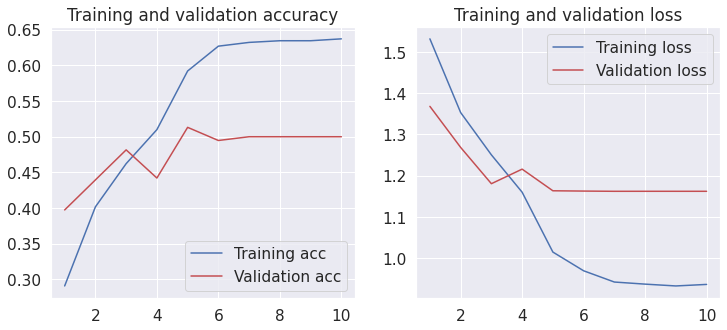

In [40]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

plot_history(history)

Loading the model with the best validation accuracy

In [41]:
def get_min_val_loss_epoch(history):
    return "0"+str(np.argmin(history.history['val_loss'])+1)

def get_max_val_acc_epoch(history):
    return "0"+str(np.argmax(history.history['val_accuracy'])+1)

In [42]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

#Block 15

**Making inference on the test data**

In [43]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

119/119 [==============================] - 21s 163ms/step


**Results**

Accuracy: 0.6374407582938388


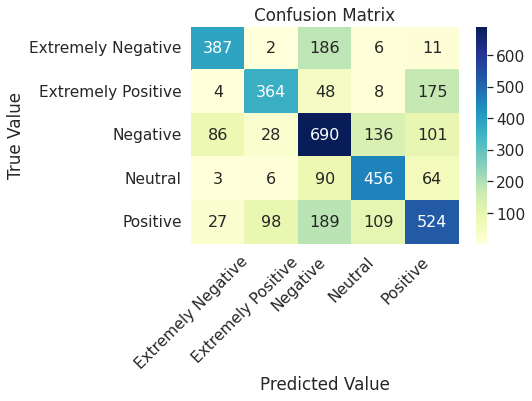

In [44]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf1(y_test, y_hat)

In [45]:
print(classification_report(y_test, y_hat, target_names=labels_5))

                    precision    recall  f1-score   support

Extremely Negative       0.76      0.65      0.70       592
Extremely Positive       0.73      0.61      0.66       599
          Negative       0.57      0.66      0.61      1041
           Neutral       0.64      0.74      0.68       619
          Positive       0.60      0.55      0.58       947

          accuracy                           0.64      3798
         macro avg       0.66      0.64      0.65      3798
      weighted avg       0.64      0.64      0.64      3798



#Block 16

## Combining Labels and Re-Running

In [46]:
def combining_labels(row):
    if row in 'Extremely Positive':        
        return 'Positive' 
    if row in 'Extremely Negative':
        return 'Negative'
    return row

### Combining Labels
train_df['Simple_Sentiment'] = train_df['Sentiment'].apply(combining_labels)
test_df['Simple_Sentiment'] = test_df['Sentiment'].apply(combining_labels)

### Encoding the labels
le = LabelEncoder()
train_df['Simple_Sentiment_label'] = le.fit_transform(train_df['Simple_Sentiment'])
test_df['Simple_Sentiment_label'] = le.transform(test_df['Simple_Sentiment'])

label_dict = (test_df[['Simple_Sentiment','Simple_Sentiment_label']].drop_duplicates()
              .sort_values(by='Simple_Sentiment_label')
              .reset_index(drop=True)['Simple_Sentiment']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Negative
1 Neutral
2 Positive


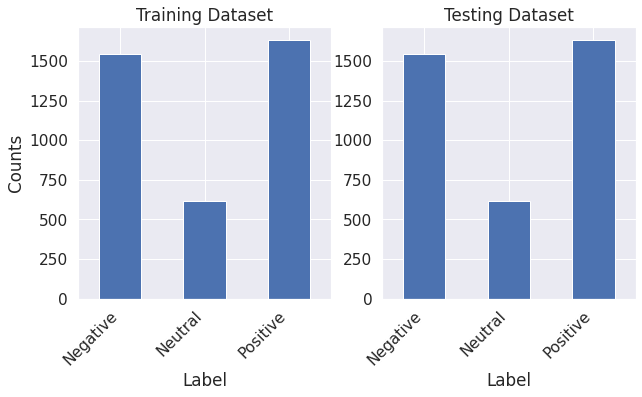

In [47]:
reorder_labels = [2,1,0]
reorder = ['Positive', 'Neutral', 'Negative']

fig, axes = plt.subplots(1,2 , figsize=(10,5))

train_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[0])
plt.sca(axes[0])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Training Dataset')
plt.ylabel('Counts')
plt.xlabel('Label')

test_df.value_counts('Simple_Sentiment_label').reindex(index=reorder_labels).plot(kind='bar', ax=axes[1])
plt.sca(axes[1])
plt.xticks(reorder_labels, reorder, rotation=45, horizontalalignment='right')
plt.title('Testing Dataset')
plt.xlabel('Label');

Splitting datasets

In [48]:
### Only need to modify the labels
y_train = train_df['Simple_Sentiment_label'][:num_train_samples]
y_val = train_df['Simple_Sentiment_label'][num_train_samples:]
y_test = test_df['Simple_Sentiment_label']

print(f"{len(y_train)} training examples\n{len(y_val)} validation examples")
print(f"{len(y_test)} testing examples")

3418 training examples
380 validation examples
3798 testing examples


### Naive Bayes (Baseline)

In [49]:
y_train_NB = train_df['Simple_Sentiment_label']
y_test_NB = test_df['Simple_Sentiment_label']

In [50]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train_NB, y_train_NB)

### Make predictions
y_hat = model.predict(X_test_NB)

**Results**

Accuracy: 0.792259083728278


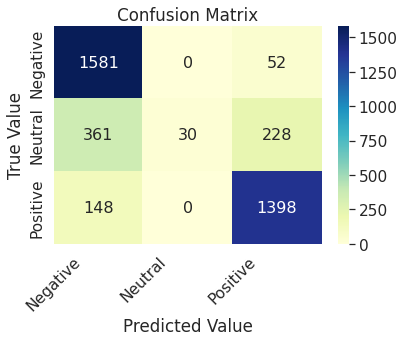

In [51]:
print("Accuracy:", accuracy_score(y_test_NB, y_hat))
labels_3 = ['Negative','Neutral','Positive'] 

def print_cf2(y_test, y_hat):
    cm = confusion_matrix(y_test, y_hat)
    sns.set(font_scale = 1.4, color_codes=True, palette="deep")
    sns.heatmap(pd.DataFrame(cm, index=labels_3,columns=[0,1,2]), 
                annot = True,
                annot_kws = {"size":16},
                fmt="d",
                cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.xticks([0,1,2], labels_3, rotation=45)
    plt.ylabel("True Value")
    plt.show()
    
print_cf2(y_test_NB, y_hat)

In [52]:
print(classification_report(y_test_NB, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.76      0.97      0.85      1633
     Neutral       1.00      0.05      0.09       619
    Positive       0.83      0.90      0.87      1546

    accuracy                           0.79      3798
   macro avg       0.86      0.64      0.60      3798
weighted avg       0.83      0.79      0.73      3798



Our baseline to beat is **63% accuracy** in our predictions

## DistilBERT

### Creating the model

In [53]:
config = DistilBertConfig.from_pretrained(MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=True)
DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
attention_mask_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = attention_mask_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, attention_mask_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 143)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 143)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 143, 768),                                                   
                                 hidden_states=((No                                         

*Creating a new output director to store the models weights*

In [54]:
### Create an output directory
output_dir = './model2_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

**Compile and train**

In [55]:
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

In [56]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    epochs = 10,
                    batch_size=16, 
                    validation_data=(X_val, y_val), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10
214/214 [==============================] - 37s 133ms/step - loss: 0.9604 - accuracy: 0.5044 - val_loss: 0.8396 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 2/10
214/214 [==============================] - ETA: 0s - loss: 0.8356 - accuracy: 0.6287
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
214/214 [==============================] - 26s 121ms/step - loss: 0.8356 - accuracy: 0.6287 - val_loss: 0.9165 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 3/10
214/214 [==============================] - 26s 119ms/step - loss: 0.7474 - accuracy: 0.6843 - val_loss: 0.7333 - val_accuracy: 0.6947 - lr: 1.0000e-04
Epoch 4/10
214/214 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.6995
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
214/214 [==============================] - 25s 119ms/step - loss: 0.7053 - accuracy: 0.6995 - val_loss: 0.7304 - val_accuracy: 0.6895 - lr: 1.0000e-04
Epoch 5/10
214/214 [================

Plotting the training accuracy and loss

Lowest Validation Loss: epoch 10
Highest Validation Accuracy: epoch 3


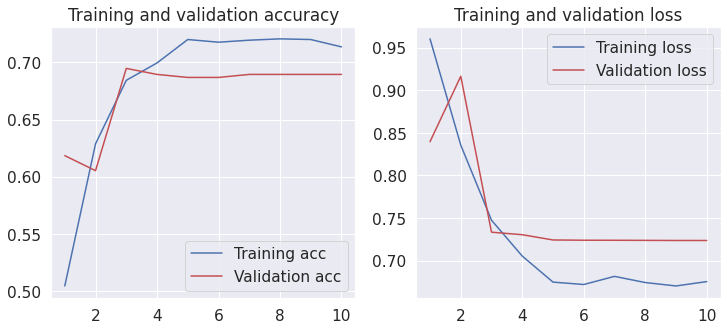

In [57]:
plot_history(history)

Loading the model weights with the best validation accuracy

In [58]:
epoch_num = get_max_val_acc_epoch(history)
model.load_weights(output_dir+"/weights."+epoch_num+".hdf5") # Load in model weights

**Making Inference**

In [59]:
y_test_probs = model.predict(X_test)

# Turn probabilities into an interger prediction
y_hat = []
for prob in y_test_probs:
    y_hat.append(np.argmax(prob))

119/119 [==============================] - 21s 162ms/step


**Results**

Accuracy: 0.710637177461822


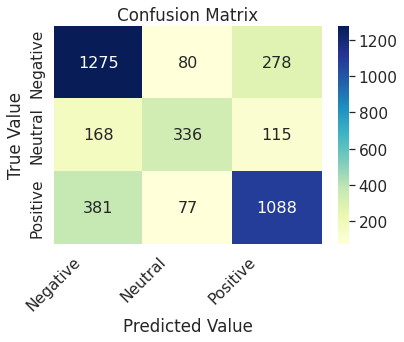

In [60]:
print("Accuracy:", accuracy_score(y_test, y_hat))
print_cf2(y_test, y_hat)

In [61]:
print(classification_report(y_test, y_hat, target_names=labels_3))

              precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1633
     Neutral       0.68      0.54      0.60       619
    Positive       0.73      0.70      0.72      1546

    accuracy                           0.71      3798
   macro avg       0.71      0.68      0.69      3798
weighted avg       0.71      0.71      0.71      3798



#Block 17

### Looking at which tweets we guessed incorrectly 

Observations that were predicted **Negative** (y_hat = 0) but actually **Positive** (y_test = 2)

*Printing the first 5 examples*

In [62]:
[print(example, '\n') for example in x_test[(y_test == 2) & (np.asarray(y_hat) == 0)][:5]];


$spx $qqq $es $nq  




 

For those thinking #seniors #disabled &amp; #vets shouldnt be included in any @realDonaldTrump aid package because of #Covid_19 #coronavirus check prices on antibacterial soaps, disinfectant safer transportation other than crowded city busses list goes on @SenStabenow @RashidaTlaib 



Same with any other Bussiness. 







Low Oil prices won't last long #OOTT  



Observations that were predicted **Positive** (y_hat = 2) but actually **Negative** (y_test = 0)

*Printing the first 5 examples*

In [63]:
[print(example, '\n') for example in x_test[(y_test == 0) & (np.asarray(y_hat) == 2)][:5]];






#Election2020 #CDC  

HI TWITTER! I am a pharmacist. I sell hand sanitizer for a living! Or I do when any exists. Like masks, it is sold the fuck out everywhere. SHOULD YOU BE WORRIED? No. Use soap. SHOULD YOU VISIT TWENTY PHARMACIES LOOKING FOR THE LAST BOTTLE? No. Pharmacies are full of sick people. 

1/25 Part 1 - Why does soap work so well on the SARS-CoV-2, the coronavirus and indeed most viruses? Because it is a self-assembled nanoparticle in which the weakest link is the lipid (fatty) bilayer. A two part thread about soap, viruses and supramolecular chemistry #COVID19  

For those self indulging in thoughts of food, medicine and essential household goods stock piling. Like people on universal credit be stock piling FFS!!! #coronavirus 

Met with members of our distributive trade today to examine their preparation   for the impact of Covid 19. Based on reports our key manufacturers and importers have at least 2 to 3 mths of stock. We therefore do not expect that there will b